# Correlation Between SDO and GOES-14 Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.time
import astropy.units as u
from astropy.visualization import quantity_support, time_support
from sunpy.net import Fido
from sunpy.net import attrs as a
import sys
from scipy.signal import savgol_filter
from scipy import stats
import pandas as pd
import cdflib
import dateutil
import dask.dataframe as dd
from dask.distributed import Client
from scipy.signal import savgol_filter
from scipy import stats
import warnings
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import netCDF4 #as nc
from scipy.io import netcdf
import glob
import xarray as xr
#from sscws.sscws import SscWs
import datetime as dt
#%matplotlib widget
#from yellowbrick.regressor import CooksDistance

# Read and Treat Data

In [3]:
# SDO
df_sdo = dd.read_parquet("/efs/sdoradbelt/data/sdo_headers", columns=['NSPIKES','WAVELNTH','GAEZ_OBS'])
df_sdo = df_sdo.set_index(df_sdo.index, sorted=True) # solve the sorting issue

# Get Equator - Non Equator Correlations

In [ ]:
p_flux_kV = [95,140,210,300,575]
telescope = 1 #choose any from 1-9
for flux in  p_flux_kV: # choose from 1 to 5
    wavelengths = [94,131,171,193,211,304,335]
    wl_p_cor_eq = []; wl_s_cor_eq = []; wl_p_cor_neq = []; wl_s_cor_neq = []; wl_p_cor_all = []; wl_s_cor_all = []
    for wl in wavelengths:
        print(wl)
        # GOES (Select Telescope, Electron Flux and Parameter)
        df_goes = dd.read_parquet("/efs/sdoradbelt/data/goes_data/magpd/goes_telescope{}_keV{}.parquet".format(telescope,flux))
        # Get headers in all wavelengths along with GOES-14 data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
        year_start = 2018; year_end = 2019
        month_start = 1; month_end = 12
        day_start = 1; day_end = 30
        start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
        cadence = '{}min'.format(1) #change to 15 minutes
        z_sdo = df_sdo[df_sdo['WAVELNTH'] == wl]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
        nspikes = df_sdo[df_sdo['WAVELNTH'] == wl]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
        uncor_flux = df_goes['uncor_flux'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
        uncor_flux[uncor_flux<0] = 0
        # Pick Equator
        nspikes_eq = []; nspikes_non_eq = []
        p_flux_eq = []; p_flux_non_eq = []
        for i in range(0,len(z_sdo)):
            if z_sdo[i] >= -2*10**6 and z_sdo[i] <= 2*10**6:
                nspikes_eq.append(nspikes[i])
                p_flux_eq.append(uncor_flux[i])
            else:
                nspikes_non_eq.append(nspikes[i])
                p_flux_non_eq.append(uncor_flux[i])
        wl_p_cor_eq.append(stats.pearsonr(nspikes_eq,p_flux_eq)[0])
        wl_s_cor_eq.append(stats.spearmanr(nspikes_eq,p_flux_eq)[0])
        wl_p_cor_neq.append(stats.pearsonr(nspikes_non_eq,p_flux_non_eq)[0])
        wl_s_cor_neq.append(stats.spearmanr(nspikes_non_eq,p_flux_non_eq)[0])
        wl_p_cor_all.append(stats.pearsonr(nspikes,uncor_flux)[0])
        wl_s_cor_all.append(stats.spearmanr(nspikes,uncor_flux)[0])
    
    # Print Correlations
    print('FLUX',flux)
    print('Equator Pearson/Spearman Correlation')
    print('r = ',np.mean(wl_p_cor_eq),'+-',np.std(wl_p_cor_eq),' / rho = ',np.mean(wl_s_cor_eq),'+-',np.std(wl_s_cor_eq))
    print('Non-Equator Pearson/Spearman Correlation')
    print('r = ',np.mean(wl_p_cor_neq),'+-',np.std(wl_p_cor_neq),' / rho = ',np.mean(wl_s_cor_neq),'+-',np.std(wl_s_cor_neq))
    print('Combined Pearson/Spearman Correlation')
    print('r = ',np.mean(wl_p_cor_all),'+-',np.std(wl_p_cor_all),' / rho = ',np.mean(wl_s_cor_all),'+-',np.std(wl_s_cor_all))
    print()

# GOES (Select Telescope, Electron Flux and Parameter)

In [13]:
# GOES (Select Telescope, Electron Flux and Parameter)
df_goes = dd.read_parquet("/efs/sdoradbelt/data/goes_data/maged/goes_telescope{}_keV{}.parquet".format(1,40))

In [5]:
# SEP 1
df_goes1 = xr.open_dataset(glob.glob('/efs/sdoradbelt/data/proton_SEP/g13_epead_cpflux_5m_20120101_20120131.nc')[0]).to_dataframe()
df_goes1 = df_goes1.set_index('time_tag')
# SEP 2
df_goes2 = xr.open_dataset(glob.glob('/efs/sdoradbelt/data/proton_SEP/g13_epead_cpflux_5m_20120301_20120331.nc')[0]).to_dataframe()
df_goes2 = df_goes2.set_index('time_tag')
# SEP 3
df_goes3 = xr.open_dataset(glob.glob('/efs/sdoradbelt/data/proton_SEP/g13_epead_cpflux_5m_20170901_20170930.nc')[0]).to_dataframe()
df_goes3 = df_goes3.set_index('time_tag')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/srv/conda/envs/notebook/lib/python3.9/site-packages

In [14]:
# Get headers in all wavelengths along with GOES-14 data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
# SEP 1
year_start = 2012; year_end = 2012; month_start = 1; month_end = 1; day_start = 23; day_end = 24
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(5) #change to 15 minutes
nspikes_304_1 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
p_flux1 = df_goes1['ZPGT10E'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().interpolate()
e_flux1 = df_goes['cor_flux'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
e_flux1[e_flux1<0] = 0.1
p_flux1[p_flux1<0] = 0
# SEP 2
year_start = 2012; year_end = 2012; month_start = 3; month_end = 3; day_start = 7; day_end = 8
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(5) #change to 15 minutes
nspikes_304_2 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
p_flux2 = df_goes2['ZPGT10E'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().interpolate()
p_flux2[p_flux2<0] = 2000
# SEP 3
year_start = 2017; year_end = 2017; month_start = 9; month_end = 9; day_start = 10; day_end = 11 #year_start = 2013; year_end = 2013; month_start = 5; month_end = 5; day_start = 22; day_end = 23
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(5) #change to 15 minutes
nspikes_304_3 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
p_flux3 = df_goes3['ZPGT10E'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().interpolate()
p_flux3[p_flux3<0] = 0
# SEP 4
#year_start = 2015; year_end = 2015; month_start = 6; month_end = 6; day_start = 21; day_end = 22
#start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
#cadence = '{}min'.format(1) #change to 15 minutes
#nspikes_304_4 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
# SEP 4
#year_start = 2017; year_end = 2017; month_start = 9; month_end = 9; day_start = 10; day_end = 11
#start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
#cadence = '{}min'.format(1) #change to 15 minutes
#nspikes_304_5 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

In [15]:
print(e_flux1)

time
2012-01-23 00:00:00   NaN
2012-01-23 00:05:00   NaN
2012-01-23 00:10:00   NaN
2012-01-23 00:15:00   NaN
2012-01-23 00:20:00   NaN
                       ..
2012-01-24 23:35:00   NaN
2012-01-24 23:40:00   NaN
2012-01-24 23:45:00   NaN
2012-01-24 23:50:00   NaN
2012-01-24 23:55:00   NaN
Freq: 5T, Name: cor_flux, Length: 576, dtype: float64


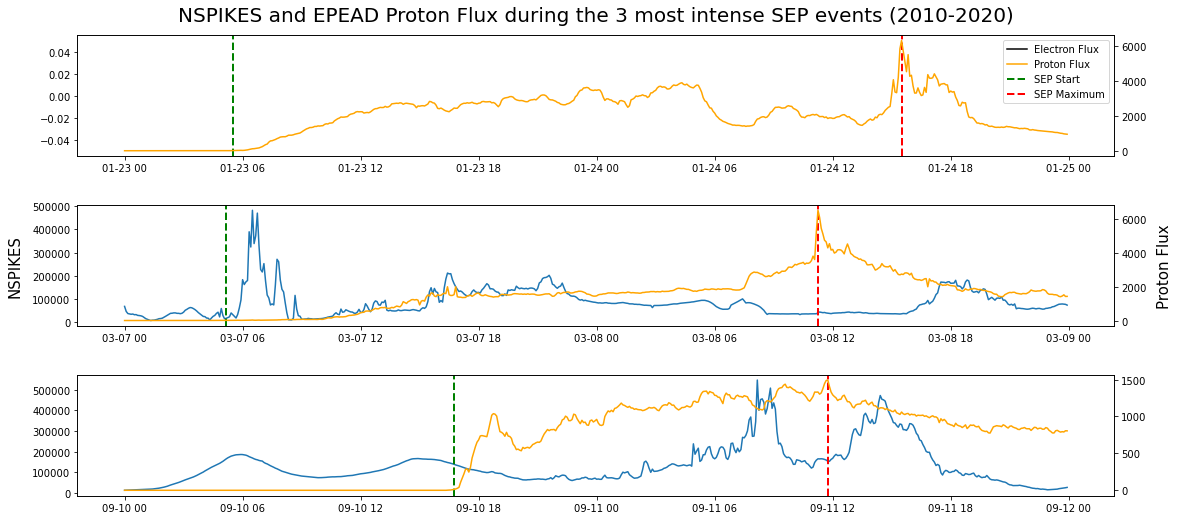

In [9]:
figure, axis = plt.subplots(3, 1, figsize=(18,8))
figure.suptitle('NSPIKES and EPEAD Proton Flux during the 3 most intense SEP events (2010-2020)',fontsize=20,y=0.95)
# SEP 1
#axis[0].plot(nspikes_304_1, label = 'NSPIKES')
axis[0].plot(e_flux1, color = 'black' , label = 'Electron Flux')
axis[0].plot([],color='orange', label = 'Proton Flux')
ax0 = axis[0].twinx() 
#ax0.set_ylabel('Y2-axis', color = 'blue') 
ax0.plot(p_flux1,color='orange') 
axis[0].axvline(dt.datetime(2012, 1, 23, 5, 30), color='g', lw = 2, ls='--', label = 'SEP Start')
axis[0].axvline(dt.datetime(2012, 1, 24, 15, 30), color='r', lw = 2, ls='--', label = 'SEP Maximum')
axis[0].legend()
# SEP 2
axis[1].plot(nspikes_304_2)
ax1 = axis[1].twinx() 
ax1.set_ylabel('Proton Flux',size=15,labelpad=10) 
ax1.plot(p_flux2,color='orange') 
axis[1].axvline(dt.datetime(2012, 3, 7, 5, 10), color='g', lw = 2, ls='--')
axis[1].axvline(dt.datetime(2012, 3, 8, 11, 15), color='r', lw = 2, ls='--')
axis[1].set_ylabel('NSPIKES',size=15,labelpad=10)
# SEP 3
axis[2].plot(nspikes_304_3)
ax2 = axis[2].twinx() 
#ax2.set_ylabel('Y2-axis') 
ax2.plot(p_flux3,color='orange') 
axis[2].axvline(dt.datetime(2017, 9, 10, 16, 45), color='g', lw = 2, ls='--')
axis[2].axvline(dt.datetime(2017, 9, 11, 11, 45), color='r', lw = 2, ls='--')
#axis[2].axvline(dt.datetime(2013, 5, 22, 14, 20), color='g', lw = 2, ls='--')
#axis[2].axvline(dt.datetime(2013, 5, 23, 6, 50), color='r', lw = 2, ls='--')
#axis[3].plot(nspikes_304_4)
#axis[3].axvline(dt.datetime(2015, 6, 21, 21, 35), color='g', lw = 2, ls='--')
#axis[3].axvline(dt.datetime(2015, 6, 22, 19, 0), color='r', lw = 2, ls='--')
#axis[3].set_ylabel('NSPIKES',size=15)
#axis[4].plot(nspikes_304_5)
#axis[4].axvline(dt.datetime(2017, 9, 10, 16, 45), color='g', lw = 2, ls='--')
#axis[4].axvline(dt.datetime(2017, 9, 11, 11, 45), color='r', lw = 2, ls='--')
#axis[4].set_ylabel('NSPIKES',size=15)
#axis[4].set_xlabel('Time',size=15,labelpad=10)
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
#plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
#plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
plt.savefig('SEP_non_Correlation.png')
plt.show()

In [ ]:
#nspikes_304[nspikes_304<0] = 0
#nspikes_94.plot(figsize=(40,10))
#plt.title('Jan-July 2012')
#plt.axvline(dt.datetime(2012, 1, 23), color='r', lw = 2, ls='--')

In [ ]:
# only do 24 h for 5 strongest events

# Equator Data Picking Plot

In [ ]:
   
# Get headers in all wavelengths along with GOES-14 data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
year_start = 2019; year_end = 2019
month_start = 10; month_end = 10
day_start = 15; day_end = 15
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(1) #change to 15 minutes
z_sdo = df_sdo[df_sdo['WAVELNTH'] == 94]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_94 = df_sdo[df_sdo['WAVELNTH'] == 94]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_131 = df_sdo[df_sdo['WAVELNTH'] == 131]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_171 = df_sdo[df_sdo['WAVELNTH'] == 171]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_193 = df_sdo[df_sdo['WAVELNTH'] == 193]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_211 = df_sdo[df_sdo['WAVELNTH'] == 211]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_304 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_335 = df_sdo[df_sdo['WAVELNTH'] == 335]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

cor_flux = []
for flux in [40,75,150,275,475]:
    # GOES (Select Telescope, Electron Flux and Parameter)
    df_goes = dd.read_parquet("/efs/sdoradbelt/data/goes_data/maged/goes_telescope{}_keV{}.parquet".format(2,flux))  
    cor_flux.append(df_goes['cor_flux'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate())


In [ ]:
# Graphing
fig, axs = plt.subplots(3,1,figsize=(30,10),gridspec_kw={'height_ratios': [1,1,1.5]})
fig.suptitle('Equator Data Selection',fontsize=27,y=0.935) #(October 15, 2019)

axs[0].plot(cor_flux[0],label='40'); axs[0].plot(cor_flux[1],label='75'); 
axs[0].plot(cor_flux[2],label='150'); axs[0].plot(cor_flux[3],label='275'); axs[0].plot(cor_flux[4],label='475')
axs[0].set_xticklabels([])
axs[0].set_ylabel('Electron Flux',fontsize=20)
axs[0].legend(loc="upper right",title='Energy (keV)',prop={'size': 14})
# units: e/(cm^2 s sr keV)

axs[1].plot(nspikes_94,label='94'); axs[1].plot(nspikes_131,label='131'); axs[1].plot(nspikes_171,label='171')
axs[1].plot(nspikes_193,label='193'); axs[1].plot(nspikes_211,label='211'); axs[1].plot(nspikes_304,label='304'); axs[1].plot(nspikes_335,label='335')
axs[1].set_xticklabels([])
#axs[0].set_ylim((0,1*10**6))
axs[1].set_ylabel('NSPIKES',fontsize=20)
axs[1].legend(loc="upper right",title=r'Wavelength ($\AA$)',prop={'size': 10})


axs[2].plot(z_sdo)
axs[2].axhline(y=-2*10**6,c='red',linewidth=0.5)
axs[2].axhline(y=2*10**6,c='red',linewidth=0.5)
axs[2].set_ylabel('SDO Latitude',fontsize=20)
axs[2].set_xlabel('Time',fontsize=20, labelpad=12)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('Equator_Selection.png')
plt.show()